In [1]:
import numpy as np
import pandas as pd
from gtda.mapper import (
    CubicalCover,
    OneDimensionalCover,
    make_mapper_pipeline,
    Projection,
    plot_static_mapper_graph,
    plot_interactive_mapper_graph
)
from gtda.mapper.cluster import ParallelClustering
from gtda.mapper import Eccentricity,Entropy

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN, KMeans,MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, OPTICS

In [2]:
import openpyxl
xlsx = pd.ExcelFile('41591_2020_897_MOESM3_ESM.xlsx')
df1 = pd.read_excel(xlsx, '(B) Figure 1B')
df3 = pd.read_excel(xlsx, '(P) ED Fig.6')

In [3]:
df3[['Days after symptoms onset']] =np.abs(df3[['Days after symptoms onset']])

In [4]:
x = df3['Patient ID']

In [5]:
r = []
for i in x:
    r.append(df1.iloc[df1.index[df1['Patient ID'] == i]].Severity.iloc[0])

In [6]:
df3['Severity'] = r

In [7]:
sum(df3['Severity'])

34

In [8]:
len(set(df3['Patient ID']))

41

In [9]:
max(df3['Days after symptoms onset'])

33

In [91]:
df3 = df3.rename({'Patient ID' : 'ID'}, axis=1)

In [92]:
df3

,ID,Days after symptoms onset,IgG (S/CO),IgM (S/CO),Severity
0,1,4,36.272,0.162,0
1,1,7,196.891,0.642,0
2,1,10,252.084,0.928,0
3,1,13,246.375,1.033,0
4,2,4,4.072,0.738,1
...,...,...,...,...,...
188,64,4,2.692,1.637,0
189,64,2,11.192,2.857,0
190,64,5,39.314,4.913,0
191,64,8,34.074,5.240,0


### Number of patients

In [93]:
count = df3.drop_duplicates(subset = ['ID'], keep = 'first', inplace = False) 
len(count)

41

### Number of several patients

In [94]:
sum(count['Severity'])

7

### Making the table with the weeks.

In [95]:
df3_week =pd.DataFrame.copy(df3)

In [96]:
aux= []
for i in range(len(df3)):
    if 0<= df3['Days after symptoms onset'][i]<8:
        aux.append('1st week')
    elif 8<= df3['Days after symptoms onset'][i]<15:
        aux.append('2nd week')
    elif 15<= df3['Days after symptoms onset'][i]<22:
        aux.append('3rd week')
    elif 22<= df3['Days after symptoms onset'][i]<29:
        aux.append('4th week')
    else:
        aux.append('5th semana')

In [97]:
df3_week['Week'] = aux

In [98]:
df3_week

,ID,Days after symptoms onset,IgG (S/CO),IgM (S/CO),Severity,Week
0,1,4,36.272,0.162,0,1st week
1,1,7,196.891,0.642,0,1st week
2,1,10,252.084,0.928,0,2nd week
3,1,13,246.375,1.033,0,2nd week
4,2,4,4.072,0.738,1,1st week
...,...,...,...,...,...,...
188,64,4,2.692,1.637,0,1st week
189,64,2,11.192,2.857,0,1st week
190,64,5,39.314,4.913,0,1st week
191,64,8,34.074,5.240,0,2nd week


# 1. 1 With patient ID, without Severity

## Filter: Eccentricity

In [99]:
filter_func = Eccentricity(exponent = 2,metric= 'cosine')
cover = OneDimensionalCover(n_intervals=100, overlap_frac=0.88, kind = 'balanced')

clusterer = DBSCAN(eps = 0.1,metric='cosine')
#clusterer = AgglomerativeClustering(n_clusters=3,linkage='single')


n_jobs = 1

# Initialise pipeline
pipe = make_mapper_pipeline(
    scaler = MinMaxScaler(),
    filter_func=filter_func,
    cover=cover,
    contract_nodes=True,
    clusterer=clusterer,
    verbose=False,
    n_jobs=n_jobs,
)

In [100]:
node_scale = 20
fig = plot_interactive_mapper_graph(pipe, 
                                    df3.drop(['Severity'],axis=1), 
                                    layout_dim=2, 
                                    node_scale=node_scale,
                                    node_color_statistic=np.mean,
                                    color_data=df3
                                   ),
fig[0]

# 1.2 With patient ID, with Severity

## Filter: Eccentricity

In [101]:
filter_func = Eccentricity(exponent = 2,metric= 'cosine')
cover = OneDimensionalCover(n_intervals=100, overlap_frac=0.88, kind = 'balanced')

clusterer = DBSCAN(eps = 0.1,metric='cosine')

n_jobs = 1

# Initialise pipeline
pipe = make_mapper_pipeline(
    scaler = MinMaxScaler(),
    filter_func=filter_func,
    cover=cover,
    contract_nodes=True,
    clusterer=clusterer,
    verbose=False,
    n_jobs=n_jobs,
)

In [102]:
node_scale = 25
fig = plot_interactive_mapper_graph(pipe, 
                                    df3, 
                                    layout_dim=2, 
                                    node_scale=node_scale,
                                    node_color_statistic=np.mean,
                                    color_data = df3),
fig[0]

### Getting resolutions parameters that yields similar figures

In [103]:
def mcd(a, b):
    temp = 0
    while b != 0:
        temp = b
        b = a % b
        a = temp
    return a

In [104]:
def ene(a,b,r1,r2):
    return (b*r2 - a*r1)/(b*r1-a*r1)

In [105]:
def li(p2,r1,r2):    
    sirve = []
    for i in range(1,p2):
        if ene(i,p2,r1,r2) - int(ene(i,p2,r1,r2)) == 0 and mcd(i,p2)==1:
            sirve.append(i)
    return np.array(sirve), np.array(sirve)/p2

The proportion of the common length of the intervals of the cover is near to $9/100$, so $r_1 = 9$ and $r_2 = 100$. We can take $p_2 =  9$ and calculate the posible values of $p_1$ with ther function ''li'' adn therefore the overlapping percentage: 

In [106]:
li(9*1,9,100)

(array([2, 8]), array([0.22222222, 0.88888889]))

Then, calculate the number of intervals in each case:

In [107]:
ene(2,9*1,9,100),ene(8,9*1,9,100)

(14.0, 92.0)

So, some resolution parameters that yields similar figures are: $$(n,p) = (14,0.22) \text{ or } (92,0.88)$$

The results with the next multiple of 9, $9\times 2$ are:

In [108]:
li(9*2,9,100)

(array([ 5, 11, 17]), array([0.27777778, 0.61111111, 0.94444444]))

In [109]:
ene(5,9*2,9,100),ene(11,9*2,9,100),ene(17,9*2,9,100)

(15.0, 27.0, 183.0)

Yields $$(n,p) = (15,0.27) \text{ or } (27,0.61) \text{ or } (183,0.94)$$

The results with the next multiple of 9, $9\times 3$ are:

In [110]:
li(9*3,9,100)

(array([14, 20, 26]), array([0.51851852, 0.74074074, 0.96296296]))

In [111]:
ene(14,9*3,9,100),ene(20,9*3,9,100),ene(26,9*3,9,100)

(22.0, 40.0, 274.0)

Yields $$(n,p) = (22,0.518) \text{ or } (40, 0.74) \text{ or } (274,0.942)$$

# Case 1.2

In [55]:
filter_func = Eccentricity(exponent = 2,metric= 'cosine')
cover = OneDimensionalCover(n_intervals=100, overlap_frac=0.88, kind = 'balanced')
#originals 100, 0.88
clusterer = DBSCAN(eps = 0.1,metric='cosine')

n_jobs = 1

# Initialise pipeline
pipe = make_mapper_pipeline(
    scaler = MinMaxScaler(),
    filter_func=filter_func,
    cover=cover,
    contract_nodes=True,
    clusterer=clusterer,
    verbose=False,
    n_jobs=n_jobs,
)

In [56]:
node_scale = 25
fig = plot_interactive_mapper_graph(pipe, 
                                    df3, 
                                    layout_dim=2, 
                                    node_scale=node_scale,
                                    node_color_statistic=np.mean,
                                    color_data = df3[["Severity", "ID"]],
                                    plotly_params = {"layout" : {"font_size":14}}
                                   ),
fig[0]

In [112]:
filter_func = Eccentricity(exponent = 2,metric= 'cosine')
cover = OneDimensionalCover(n_intervals=100, overlap_frac=0.88, kind = 'balanced')
#originals 100, 0.88
clusterer = DBSCAN(eps = 0.1,metric='cosine')

n_jobs = 1

# Initialise pipeline
pipe = make_mapper_pipeline(
    scaler = MinMaxScaler(),
    filter_func=filter_func,
    cover=cover,
    contract_nodes=True,
    clusterer=clusterer,
    verbose=False,
    n_jobs=n_jobs,
)
node_scale = 25
fig = plot_static_mapper_graph(pipe, 
                                    df3, 
                                    layout_dim=2, 
                                    node_scale=node_scale,
                                    node_color_statistic=np.mean,
                                    color_data = df3[["IgM (S/CO)"]],
                                    plotly_params = {"layout" : {"font_size":14}}
                                   )
fig.write_image("images/seq_gen_IgM2.pdf")

In [113]:
filter_func = Eccentricity(exponent = 2,metric= 'cosine')
cover = OneDimensionalCover(n_intervals=100, overlap_frac=0.88, kind = 'balanced')
#originals 100, 0.88
clusterer = DBSCAN(eps = 0.1,metric='cosine')

n_jobs = 1

# Initialise pipeline
pipe = make_mapper_pipeline(
    scaler = MinMaxScaler(),
    filter_func=filter_func,
    cover=cover,
    contract_nodes=True,
    clusterer=clusterer,
    verbose=False,
    n_jobs=n_jobs,
)
node_scale = 25
fig = plot_static_mapper_graph(pipe, 
                                    df3, 
                                    layout_dim=2, 
                                    node_scale=node_scale,
                                    node_color_statistic=np.mean,
                                    color_data = df3[["Days after symptoms onset"]],
                                    plotly_params = {"layout" : {"font_size":14}}
                                   )
fig.write_image("images/seq_gen_Days2.pdf")

In [114]:
filter_func = Eccentricity(exponent = 2,metric= 'cosine')
cover = OneDimensionalCover(n_intervals=100, overlap_frac=0.88, kind = 'balanced')
#originals 100, 0.88
clusterer = DBSCAN(eps = 0.1,metric='cosine')

n_jobs = 1

# Initialise pipeline
pipe = make_mapper_pipeline(
    scaler = MinMaxScaler(),
    filter_func=filter_func,
    cover=cover,
    contract_nodes=True,
    clusterer=clusterer,
    verbose=False,
    n_jobs=n_jobs,
)
node_scale = 25
fig = plot_static_mapper_graph(pipe, 
                                    df3, 
                                    layout_dim=2, 
                                    node_scale=node_scale,
                                    node_color_statistic=np.mean,
                                    color_data = df3[["Severity"]],
                                    plotly_params = {"layout" : {"font_size":14}}
                                   )
fig.write_image("images/seq_gen_Severity2.pdf")

## Another parameters

In [115]:
filter_func = Eccentricity(exponent = 2,metric= 'cosine')
cover = OneDimensionalCover(n_intervals=14, overlap_frac=0.22, kind = 'balanced')
#originals 100, 0.88
clusterer = DBSCAN(eps = 0.1,metric='cosine')

n_jobs = 1

# Initialise pipeline
pipe = make_mapper_pipeline(
    scaler = MinMaxScaler(),
    filter_func=filter_func,
    cover=cover,
    contract_nodes=True,
    clusterer=clusterer,
    verbose=False,
    n_jobs=n_jobs,
)
node_scale = 25
fig = plot_static_mapper_graph(pipe, 
                                    df3, 
                                    layout_dim=2, 
                                    node_scale=node_scale,
                                    node_color_statistic=np.mean,
                                    color_data = df3[["Severity"]],
                                    plotly_params = {"layout" : {"font_size":14}}
                                   )
fig.write_image("images/1422.pdf")

In [116]:
filter_func = Eccentricity(exponent = 2,metric= 'cosine')
cover = OneDimensionalCover(n_intervals=22, overlap_frac=0.51, kind = 'balanced')
#originals 100, 0.88
clusterer = DBSCAN(eps = 0.1,metric='cosine')

n_jobs = 1

# Initialise pipeline
pipe = make_mapper_pipeline(
    scaler = MinMaxScaler(),
    filter_func=filter_func,
    cover=cover,
    contract_nodes=True,
    clusterer=clusterer,
    verbose=False,
    n_jobs=n_jobs,
)
node_scale = 25
fig = plot_static_mapper_graph(pipe, 
                                    df3, 
                                    layout_dim=2, 
                                    node_scale=node_scale,
                                    node_color_statistic=np.mean,
                                    color_data = df3[["Severity"]],
                                    plotly_params = {"layout" : {"font_size":14}}
                                   )
fig.write_image("images/2251.pdf")

In [117]:
filter_func = Eccentricity(exponent = 2,metric= 'cosine')
cover = OneDimensionalCover(n_intervals=92, overlap_frac=0.88, kind = 'balanced')
#originals 100, 0.88
clusterer = DBSCAN(eps = 0.1,metric='cosine')

n_jobs = 1

# Initialise pipeline
pipe = make_mapper_pipeline(
    scaler = MinMaxScaler(),
    filter_func=filter_func,
    cover=cover,
    contract_nodes=True,
    clusterer=clusterer,
    verbose=False,
    n_jobs=n_jobs,
)
node_scale = 25
fig = plot_static_mapper_graph(pipe, 
                                    df3, 
                                    layout_dim=2, 
                                    node_scale=node_scale,
                                    node_color_statistic=np.mean,
                                    color_data = df3[["Severity"]],
                                    plotly_params = {"layout" : {"font_size":14}}
                                   )
fig.write_image("images/9288.pdf")

In [118]:
filter_func = Eccentricity(exponent = 2,metric= 'cosine')
cover = OneDimensionalCover(n_intervals=27, overlap_frac=0.61, kind = 'balanced')
#originals 100, 0.88
clusterer = DBSCAN(eps = 0.1,metric='cosine')

n_jobs = 1

# Initialise pipeline
pipe = make_mapper_pipeline(
    scaler = MinMaxScaler(),
    filter_func=filter_func,
    cover=cover,
    contract_nodes=True,
    clusterer=clusterer,
    verbose=False,
    n_jobs=n_jobs,
)
node_scale = 25
fig = plot_static_mapper_graph(pipe, 
                                    df3, 
                                    layout_dim=2, 
                                    node_scale=node_scale,
                                    node_color_statistic=np.mean,
                                    color_data = df3[["Severity"]],
                                    plotly_params = {"layout" : {"font_size":14}}
                                   )
fig.write_image("images/2761.pdf")

In [119]:
filter_func = Eccentricity(exponent = 2,metric= 'cosine')
cover = OneDimensionalCover(n_intervals=183, overlap_frac=0.94, kind = 'balanced')
#originals 100, 0.88
clusterer = DBSCAN(eps = 0.1,metric='cosine')

n_jobs = 1

# Initialise pipeline
pipe = make_mapper_pipeline(
    scaler = MinMaxScaler(),
    filter_func=filter_func,
    cover=cover,
    contract_nodes=True,
    clusterer=clusterer,
    verbose=False,
    n_jobs=n_jobs,
)
node_scale = 25
fig = plot_static_mapper_graph(pipe, 
                                    df3, 
                                    layout_dim=2, 
                                    node_scale=node_scale,
                                    node_color_statistic=np.mean,
                                    color_data = df3[["Severity"]],
                                    plotly_params = {"layout" : {"font_size":14}}
                                   )
fig.write_image("images/18394.pdf")

In [120]:
filter_func = Eccentricity(exponent = 2,metric= 'cosine')
cover = OneDimensionalCover(n_intervals=40, overlap_frac=0.74, kind = 'balanced')
#originals 100, 0.88
clusterer = DBSCAN(eps = 0.1,metric='cosine')

n_jobs = 1

# Initialise pipeline
pipe = make_mapper_pipeline(
    scaler = MinMaxScaler(),
    filter_func=filter_func,
    cover=cover,
    contract_nodes=True,
    clusterer=clusterer,
    verbose=False,
    n_jobs=n_jobs,
)
node_scale = 25
fig = plot_static_mapper_graph(pipe, 
                                    df3, 
                                    layout_dim=2, 
                                    node_scale=node_scale,
                                    node_color_statistic=np.mean,
                                    color_data = df3[["Severity"]],
                                    plotly_params = {"layout" : {"font_size":14}}
                                   )
fig.write_image("images/4074.pdf")

In [121]:
filter_func = Eccentricity(exponent = 2,metric= 'cosine')
cover = OneDimensionalCover(n_intervals=274, overlap_frac=0.96, kind = 'balanced')
#originals 100, 0.88
clusterer = DBSCAN(eps = 0.1,metric='cosine')

n_jobs = 1

# Initialise pipeline
pipe = make_mapper_pipeline(
    scaler = MinMaxScaler(),
    filter_func=filter_func,
    cover=cover,
    contract_nodes=True,
    clusterer=clusterer,
    verbose=False,
    n_jobs=n_jobs,
)
node_scale = 25
fig = plot_static_mapper_graph(pipe, 
                                    df3, 
                                    layout_dim=2, 
                                    node_scale=node_scale,
                                    node_color_statistic=np.mean,
                                    color_data = df3[["Severity"]],
                                    plotly_params = {"layout" : {"font_size":14}}
                                   )
fig.write_image("images/27496.pdf")

In [122]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

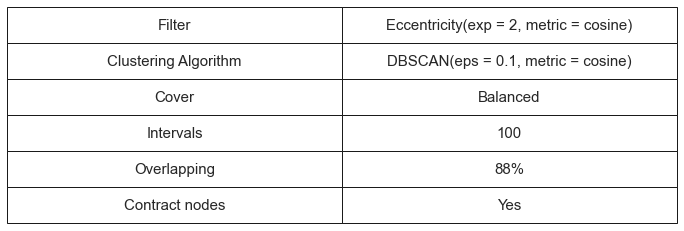

In [123]:
meta_table = plt.table(cellText=[['Filter', 'Eccentricity(exp = 2, metric = cosine)'], 
     ['Clustering Algorithm', 'DBSCAN(eps = 0.1, metric = cosine)'],
     ['Cover', 'Balanced'],
     ['Intervals', '100'],
     ['Overlapping', '88%'],
     ['Contract nodes', 'Yes']],
         cellLoc = 'center',
         loc = 'center',
         colLoc = 'center',
         rowLoc = 'center',
         #cellColours = [['#93D4F6','w'],['#93D4F6','w'],['#93D4F6','w'],['#93D4F6','w'],['#93D4F6','w'],['#93D4F6','w']],
         edges = 'closed',
         #colWidths = [0.05,0.20,0.10,0.10,0.10]
         )
plt.axis('off')
meta_table.auto_set_font_size(False)
meta_table.set_fontsize(15)
meta_table.scale(2,3)
meta_fig = meta_table.figure

pp = PdfPages("tabind2.pdf")
pp.savefig(meta_fig, bbox_inches='tight')
pp.close()

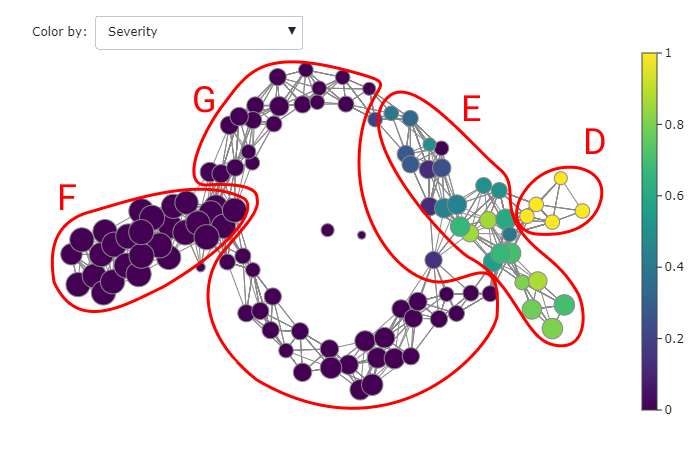

In [124]:
from IPython import display
display.Image("./g32.png")

# Constructing the table for groups D, E, F and G.

In [125]:
filter_func = Eccentricity(exponent = 2,metric= 'cosine')
cover = OneDimensionalCover(n_intervals=100, overlap_frac=0.88, kind = 'balanced')
#originals 100, 0.88
clusterer = DBSCAN(eps = 0.1,metric='cosine')

n_jobs = 1

# Initialise pipeline
pipe = make_mapper_pipeline(
    scaler = MinMaxScaler(),
    filter_func=filter_func,
    cover=cover,
    contract_nodes=True,
    clusterer=clusterer,
    verbose=False,
    n_jobs=n_jobs,
)

In [126]:
node_scale = 25
fig = plot_interactive_mapper_graph(pipe, 
                                    df3, 
                                    layout_dim=2, 
                                    node_scale=node_scale,
                                    node_color_statistic=np.mean,
                                    color_data = df3[["Severity", "ID"]],
                                    plotly_params = {"layout" : {"font_size":14}}
                                   ),
fig[0]

In [127]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from seaborn import histplot as hist
sns.set_theme(style="whitegrid")
%matplotlib inline

In [128]:
graph = pipe.fit_transform(df3)
node_elements = graph.vs["node_elements"]

In [129]:
len(node_elements)

111

### Groups of nodes:
- Group $D$: Nodes with $100\%$ of samples from severe patients.
- Group $E$: Nodes with $40\%-90\%$.
- Group $F\cup G$: Nodes with $0\%$.
- Group $F$: Nodes with at least $12$ samples of $F\cup G$.
- Group $G$: Rest of the nodes of $F\cup G$.

In [130]:
group_D_id = []
group_E_id = []
group_F_id = []
group_G_id = []
group_FuG_id = []
group_Gd_id = []
group_Gu_id = []
for i in range(len(node_elements)):
    if 1 <= np.mean(df3_week.iloc[node_elements[i]]['Severity']):
        group_D_id.append(i)
    elif 0.4 <= np.mean(df3_week.iloc[node_elements[i]]['Severity'])<=0.9:
        group_E_id.append(i)
    elif 0 == np.mean(df3_week.iloc[node_elements[i]]['Severity']):
        group_FuG_id.append(i)

group_D_id = list(set(group_D_id))
group_E_id = list(set(group_E_id))
group_FuG_id = list(set(group_FuG_id))

for i in group_FuG_id:
    if 11 < len(df3_week.iloc[node_elements[i]]):
            group_F_id.append(i)
    else:
        group_G_id.append(i)
        
for i in group_G_id:
    if np.max(df3_week.iloc[node_elements[i]]['ID'])>= 53:
        group_Gd_id.append(i)
    else:
        group_Gu_id.append(i)
        
group_F_id = list(set(group_F_id))
group_G_id = list(set(group_G_id))
group_Gd_id = list(set(group_Gd_id))
group_Gu_id = list(set(group_Gu_id))

In [131]:
group_D_id, group_E_id, len(group_FuG_id), len(group_F_id) , len(group_G_id) 

([34, 35, 68, 70, 6],
 [0, 1, 2, 3, 4, 5, 7, 8, 9, 24, 32, 33, 69, 71, 72, 73, 74, 75, 82],
 79,
 27,
 52)

### Recovering the samples of each node.

In [132]:
graph = pipe.fit_transform(df3)
def Nodes(nodes, data,pipe):
    graph = pipe.fit_transform(data)
    node_id = []
    node_elements = graph.vs["node_elements"]
    ne = []
    da = []
    data_points = []
    for i in nodes:
        node_id.append(i)
        ne.append(node_elements[node_id[-1]])
        x = np.asarray(df3_week.iloc[node_elements[node_id[-1]]])
        data_points.append(x)    
    return node_id,ne,data_points

In [133]:
ad,bd,d = Nodes(group_D_id, df3, pipe)
ae,be,e = Nodes(group_E_id, df3, pipe)
af,bf,f = Nodes(group_F_id, df3, pipe)
ag,bg,g = Nodes(group_G_id, df3, pipe)
afug,bfug,fug = Nodes(group_FuG_id, df3, pipe)

agd, bgd, gd = Nodes(group_Gd_id, df3, pipe)
agu, bgu, gu = Nodes(group_Gu_id, df3, pipe)

In [134]:
d

[array([[5, 4, 0.221, 0.231, 1, '1st week'],
        [5, 7, 1.258, 1.584, 1, '1st week'],
        [12, 9, 0.767, 0.562, 1, '2nd week'],
        [15, 10, 0.7, 2.794, 1, '2nd week']], dtype=object),
 array([[5, 7, 1.258, 1.584, 1, '1st week'],
        [12, 9, 0.767, 0.562, 1, '2nd week'],
        [12, 12, 4.472, 6.35, 1, '2nd week'],
        [15, 10, 0.7, 2.794, 1, '2nd week'],
        [34, 2, 8.848, 14.059, 1, '1st week']], dtype=object),
 array([[12, 9, 0.767, 0.562, 1, '2nd week'],
        [12, 12, 4.472, 6.35, 1, '2nd week'],
        [12, 15, 8.257, 18.932, 1, '3rd week'],
        [15, 10, 0.7, 2.794, 1, '2nd week'],
        [15, 13, 2.771, 4.924, 1, '2nd week']], dtype=object),
 array([[12, 12, 4.472, 6.35, 1, '2nd week'],
        [12, 15, 8.257, 18.932, 1, '3rd week'],
        [15, 10, 0.7, 2.794, 1, '2nd week'],
        [15, 13, 2.771, 4.924, 1, '2nd week'],
        [15, 16, 6.831, 7.445, 1, '3rd week']], dtype=object),
 array([[2, 4, 4.072, 0.738, 1, '1st week'],
        [3, 4, 4

In [135]:
len(f), len(g), len(fug)

(27, 52, 79)

In [149]:
def table(x):
    IgGg = []
    IgMg = []
    #GMg = []
    #Daysg = []
    #Severig = []

    for i in range(len(x)):
        IgGg.append(np.array([[x[i][k][0], x[i][k][1], x[i][k][2], x[i][k][4], x[i][k][-1]] for k in range(len(x[i]))]))
        IgMg.append(np.array([[x[i][k][0], x[i][k][1], x[i][k][3], x[i][k][4], x[i][k][-1]] for k in range(len(x[i]))]))

    IgGg = np.unique(np.concatenate(IgGg),axis = 0)
    IgMg = np.unique(np.concatenate(IgMg),axis = 0)
    IgGg = pd.DataFrame(IgGg, columns = ['ID', 'Days', 'Antibody level', 'Severity','Week'])
    IgMg = pd.DataFrame(IgMg, columns = ['ID', 'Days', 'Antibody level', 'Severity','Week'])
    
    #sever_IgG = IgGg[IgGg['Severity'] == '1']
    #not_sever_IgG = IgGg[IgGg['Severity'] == '0']
    #sever_IgM = IgMg[IgMg['Severity'] == '1']
    #not_sever_IgM = IgMg[IgMg['Severity'] == '0']
    
    #IgG_group_x = pd.concat([sever_IgG, not_sever_IgG])
    IgG_group_x = IgGg
    
    #IgM_group_x = pd.concat([sever_IgM, not_sever_IgM])
    IgM_group_x = IgMg
    
    for i in range(len(IgG_group_x)):
        if IgG_group_x['Severity'][i] == '1':
            IgG_group_x['Severity'][i] = 'Severe'
        elif IgG_group_x['Severity'][i] == '0':
            IgG_group_x['Severity'][i] = 'Nom-severe'
        
    for i in range(len(IgM_group_x)):
        if IgM_group_x['Severity'][i] == '1':
            IgM_group_x['Severity'][i] = 'Severe'
        elif IgM_group_x['Severity'][i] == '0':
            IgM_group_x['Severity'][i] = 'No-severe'
            
    IgG_group_x = IgG_group_x.astype({"ID": int, "Days": int, "Antibody level": float, "Severity": str, "Week": str})
    IgM_group_x = IgM_group_x.astype({"ID": int, "Days": int, "Antibody level": float, "Severity": str, "Week": str})

    IgG_group_x['Antibody level'] = np.log2(IgG_group_x['Antibody level'])
    IgM_group_x['Antibody level'] = np.log2(IgM_group_x['Antibody level'])
    
    IgG_group_x = IgG_group_x.sort_values(by=['ID', 'Days'])
    IgM_group_x = IgM_group_x.sort_values(by=['ID', 'Days'])
    
    print('Max. day:', max(IgG_group_x['Days']))
    return IgG_group_x, IgM_group_x

### Tables of each group

In [150]:
IgG_group_D, IgM_group_D = table(d)

Max. day: 16


In [151]:
IgG_group_E, IgM_group_E = table(e)

Max. day: 29


In [152]:
IgG_group_F, IgM_group_F = table(f)

Max. day: 28


In [140]:
IgG_group_G, IgM_group_G = table(g)

Max. day: 33


In [141]:
IgG_group_FuG, IgM_group_FuG = table(fug)

Max. day: 33


In [142]:
IgG_group_Gd, IgM_group_Gd = table(gd)

Max. day: 18


In [157]:
IgG_group_Gu, IgM_group_Gu = table(gu)

Max. day: 33


In [158]:
len(IgG_group_F),len(IgG_group_G), len(IgG_group_FuG) 

(62, 105, 144)

**Note**: It shouldn't sum $144$ because there are nodes in $F$ that share samples with nodes in $G$.

In [159]:
def times(dataG, dataM, st,a,b):
    ID_unique = dataG.sort_values(by = ['ID'])['ID'].unique()
    np.random.seed(5)
    mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(ID_unique), replace=False)


    fig, ax = plt.subplots(1,2, figsize=(13,4), sharey = True)
    for i, y  in enumerate(ID_unique):        
            #if i > 0:
                ax[0].plot('Days', 'Antibody level', 
                           data=dataG.loc[dataG.ID==y, :], 
                           color=mycolors[i], 
                           label=y,
                           linewidth=2,
                           marker=".", 
                           markersize=8)

    for i, y  in enumerate(ID_unique):        
            #if i > 0:
                ax[1].plot('Days', 'Antibody level', 
                           data=dataM.loc[dataM.ID==y, :], 
                           color=mycolors[i], 
                           label=y,
                           linewidth=2,
                           marker=".", 
                           markersize=8)



    ax[0].set_title('IgG', fontsize=15)
    ax[1].set_title('IgM', fontsize=15)

    ax[0].set_xlabel('Days')
    ax[1].set_xlabel('Days')

    ax[0].set_ylabel('$\log_2$(Antiboy level)')

    ax[0].set_xlim(a, b)
    ax[1].set_xlim(a, b)

    ax[0].set_ylim(-3.5, 10)
    ax[1].set_ylim(-3.5, 10)

    lines, labels = ax[0].get_legend_handles_labels()
    lines2, labels2 = ax[1].get_legend_handles_labels()

    ax[0].legend(lines, labels,bbox_to_anchor=(2.6, 0.5),loc = 'center right' ,ncol=2,title="ID")
    #ax[1].legend(lines2, labels2, loc='upper right')

    #plt.suptitle('Grupo {0}'.format(st).replace("f", ""), fontsize=20)
    plt.savefig('{0}.pdf'.format(st),bbox_inches='tight')
    plt.show()

### Group D

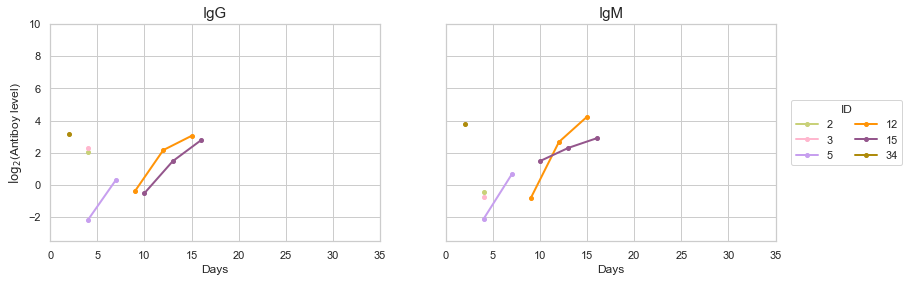

In [160]:
times(IgG_group_D, IgM_group_D, 'D', 0, 35)

### Group E

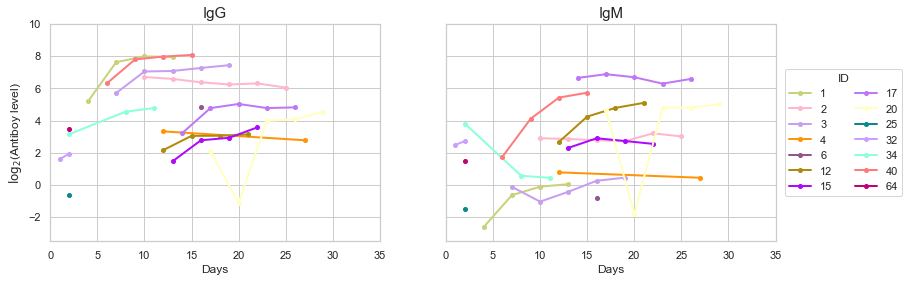

In [161]:
times(IgG_group_E, IgM_group_E, 'E', 0, 35)

### Group F

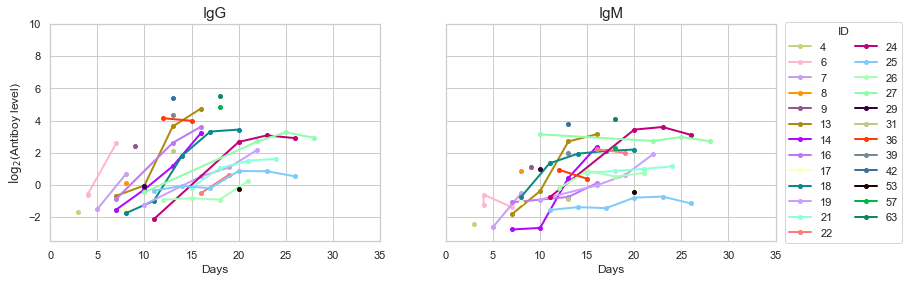

In [162]:
times(IgG_group_F,IgM_group_F, 'F', 0, 35)

### Group G

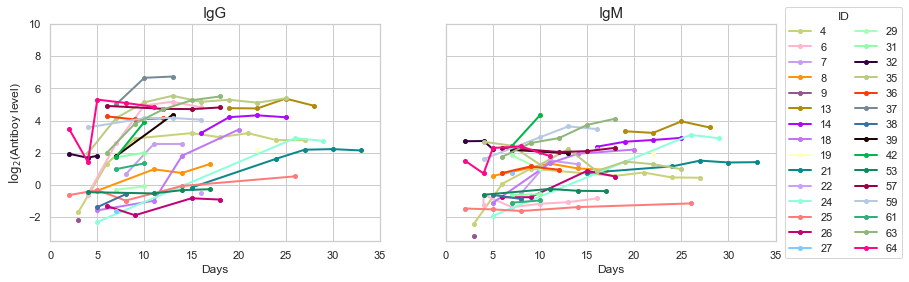

In [163]:
times(IgG_group_G, IgM_group_G, 'G', 0, 35)

### First two weeks

In [164]:
first_weeks_IgG_D = pd.concat([IgG_group_D[IgG_group_D['Week'] =='1st week'], IgG_group_D[IgG_group_D['Week'] =='2nd week']])
first_weeks_IgG_E = pd.concat([IgG_group_E[IgG_group_E['Week'] =='1st week'], IgG_group_E[IgG_group_E['Week'] =='2nd week']])
first_weeks_IgG_F = pd.concat([IgG_group_F[IgG_group_F['Week'] =='1st week'], IgG_group_F[IgG_group_F['Week'] =='2nd week']])
first_weeks_IgG_G = pd.concat([IgG_group_G[IgG_group_G['Week'] =='1st week'], IgG_group_G[IgG_group_G['Week'] =='2nd week']])

#first_weeks_IgG_AuB = pd.concat([IgG_group_AuB[IgG_group_AuB['Week'] =='1st week'], IgG_group_AuB[IgG_group_AuB['Week'] =='2nd week']])


first_weeks_IgM_D = pd.concat([IgM_group_D[IgM_group_D['Week'] =='1st week'], IgM_group_D[IgM_group_D['Week'] =='2nd week']])
first_weeks_IgM_E = pd.concat([IgM_group_E[IgM_group_E['Week'] =='1st week'], IgM_group_E[IgM_group_E['Week'] =='2nd week']])
first_weeks_IgM_F = pd.concat([IgM_group_F[IgM_group_F['Week'] =='1st week'], IgM_group_F[IgM_group_F['Week'] =='2nd week']])
first_weeks_IgM_G = pd.concat([IgM_group_G[IgM_group_G['Week'] =='1st week'], IgM_group_G[IgM_group_G['Week'] =='2nd week']])

#first_weeks_IgM_AuB = pd.concat([IgM_group_AuB[IgM_group_AuB['Week'] =='1st week'], IgM_group_AuB[IgM_group_AuB['Week'] =='2nd week']])


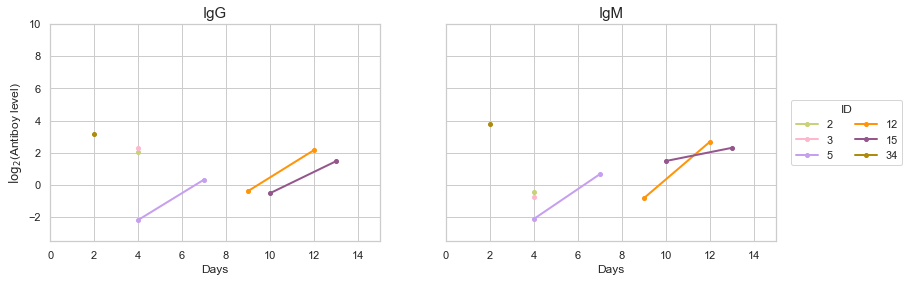

In [165]:
times(first_weeks_IgG_D, first_weeks_IgM_D, 'Df', 0, 15)

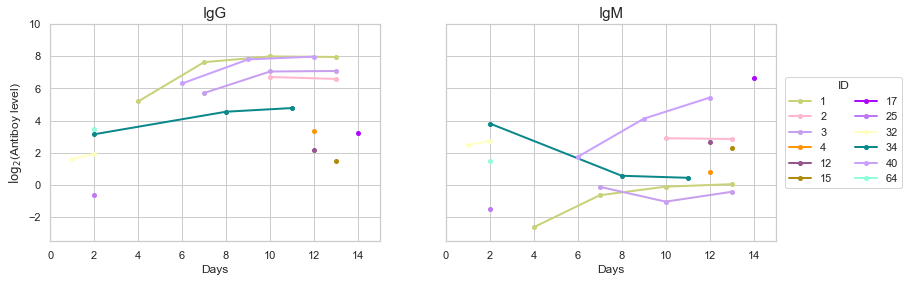

In [166]:
times(first_weeks_IgG_E, first_weeks_IgM_E, 'Ef', 0, 15)

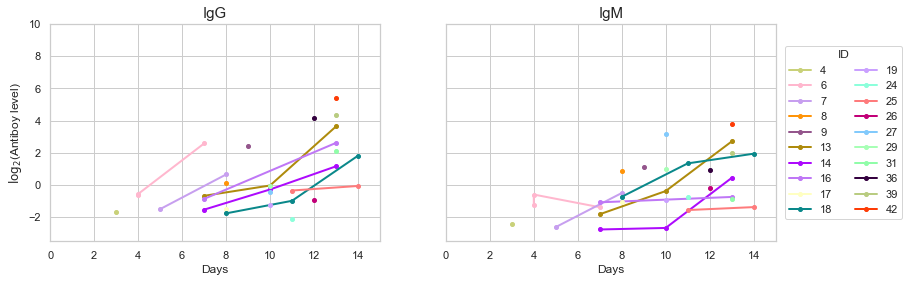

In [167]:
times(first_weeks_IgG_F, first_weeks_IgM_F, 'Ff', 0, 15)

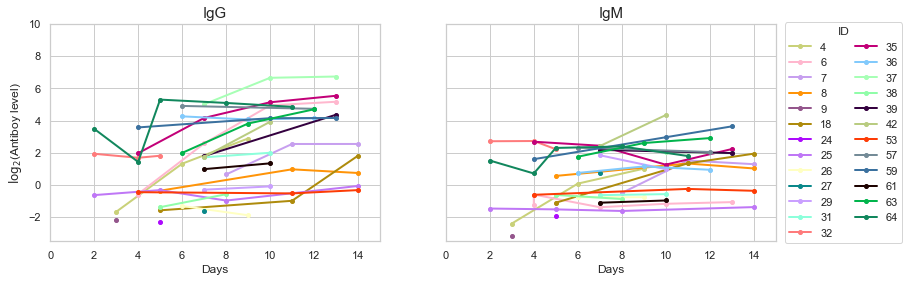

In [168]:
times(first_weeks_IgG_G, first_weeks_IgM_G, 'Gf', 0, 15)

In [169]:
df3_week

,ID,Days after symptoms onset,IgG (S/CO),IgM (S/CO),Severity,Week
0,1,4,36.272,0.162,0,1st week
1,1,7,196.891,0.642,0,1st week
2,1,10,252.084,0.928,0,2nd week
3,1,13,246.375,1.033,0,2nd week
4,2,4,4.072,0.738,1,1st week
...,...,...,...,...,...,...
188,64,4,2.692,1.637,0,1st week
189,64,2,11.192,2.857,0,1st week
190,64,5,39.314,4.913,0,1st week
191,64,8,34.074,5.240,0,2nd week


In [170]:
first_weeks_IgG_E[first_weeks_IgG_E['Severity'] == 'Severe']

,ID,Days,Antibody level,Severity,Week
33,3,7,5.704180,Severe,1st week
37,34,2,3.145351,Severe,1st week
17,2,10,6.701133,Severe,2nd week
18,2,13,6.580176,Severe,2nd week
29,3,10,7.042393,Severe,2nd week
30,3,13,7.074505,Severe,2nd week
4,12,12,2.160920,Severe,2nd week
8,15,13,1.470407,Severe,2nd week
38,34,8,4.545660,Severe,2nd week
36,34,11,4.773205,Severe,2nd week


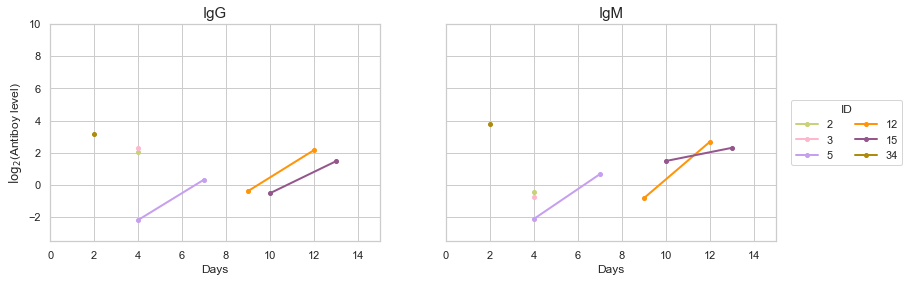

In [171]:
times(first_weeks_IgG_D[first_weeks_IgG_D['Severity'] == 'Severe'], first_weeks_IgM_D[first_weeks_IgG_D['Severity'] == 'Severe'], 'Dff', 0, 15)

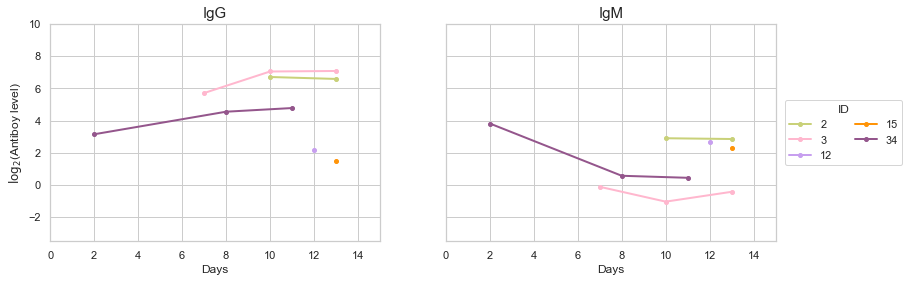

In [172]:
times(first_weeks_IgG_E[first_weeks_IgG_E['Severity'] == 'Severe'], first_weeks_IgM_E[first_weeks_IgG_E['Severity'] == 'Severe'], 'Eff', 0, 15)

In [173]:
s1 = first_weeks_IgG_D.sort_values(by = ['ID']).sort_values(by = ['Days'])
s2 = first_weeks_IgG_E.sort_values(by = ['ID']).sort_values(by = ['Days'])

In [174]:
s1 = s1[s1['ID']==5].append(s1[s1['ID']==12]).append(s1[s1['ID']==15])
s2 = s2[s2['ID']==2].append(s2[s2['ID']==3]).append(s2[s2['ID']==34])

In [175]:
s1

,ID,Days,Antibody level,Severity,Week
9,5,4,-2.177882,Severe,1st week
10,5,7,0.331132,Severe,1st week
2,12,9,-0.382702,Severe,2nd week
0,12,12,2.160920,Severe,2nd week
3,15,10,-0.514573,Severe,2nd week
4,15,13,1.470407,Severe,2nd week


In [176]:
s2

,ID,Days,Antibody level,Severity,Week
17,2,10,6.701133,Severe,2nd week
18,2,13,6.580176,Severe,2nd week
33,3,7,5.704180,Severe,1st week
29,3,10,7.042393,Severe,2nd week
30,3,13,7.074505,Severe,2nd week
37,34,2,3.145351,Severe,1st week
38,34,8,4.545660,Severe,2nd week
36,34,11,4.773205,Severe,2nd week


In [177]:
total1 = df3.sort_values(by = ['ID']).sort_values(by = ['Days after symptoms onset'])
total2 = df3.sort_values(by = ['ID']).sort_values(by = ['Days after symptoms onset'])

total1 = total1.rename({'Days after symptoms onset': 'Days'}, axis=1)
total2 = total2.rename({'Days after symptoms onset': 'Days'}, axis=1)

In [178]:
total1 = total1[total1['ID']==5].append(total1[total1['ID']==12]).append(total1[total1['ID']==15])
total2 = total2[total2['ID']==2].append(total2[total2['ID']==3]).append(total2[total2['ID']==34])

In [179]:
total1['IgG (S/CO)'] = np.log2(total1['IgG (S/CO)'])
total1['IgM (S/CO)'] = np.log2(total1['IgM (S/CO)'])

total2['IgG (S/CO)'] = np.log2(total2['IgG (S/CO)'])
total2['IgM (S/CO)'] = np.log2(total2['IgM (S/CO)'])

In [181]:
total1_IgG = total1.rename({'IgG (S/CO)': 'Antibody level'}, axis=1)
total1_IgM = total1.rename({'IgM (S/CO)': 'Antibody level'}, axis=1)

total2_IgG = total2.rename({'IgG (S/CO)': 'Antibody level'}, axis=1)
total2_IgM = total2.rename({'IgM (S/CO)': 'Antibody level'}, axis=1)

# Pacientes 5, 12 y 15

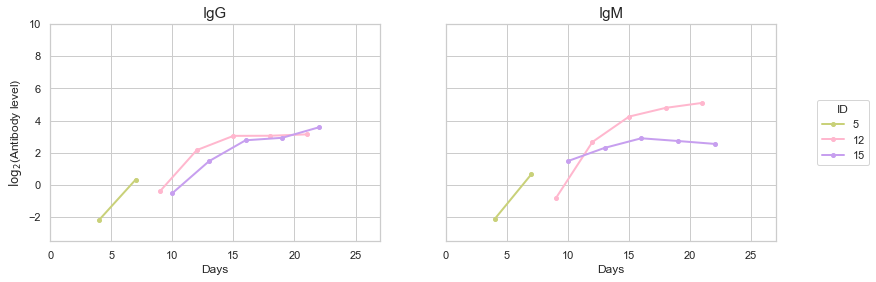

In [182]:
ID_unique = total1_IgG.sort_values(by = ['ID'])['ID'].unique()
np.random.seed(5)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(ID_unique), replace=False)


fig, ax = plt.subplots(1,2, figsize=(13,4), sharey = True)
for i, y  in enumerate(ID_unique):        
            #if i > 0:
                ax[0].plot('Days', 'Antibody level', 
                           data=total1_IgG.loc[total1_IgG.ID==y, :], 
                           color=mycolors[i], 
                           label=y,
                           linewidth=2,
                           marker=".", 
                           markersize=8)

for i, y  in enumerate(ID_unique):        
            #if i > 0:
                ax[1].plot('Days', 'Antibody level', 
                           data=total1_IgM.loc[total1_IgM.ID==y, :], 
                           color=mycolors[i], 
                           label=y,
                           linewidth=2,
                           marker=".", 
                           markersize=8)



ax[0].set_title('IgG', fontsize=15)
ax[1].set_title('IgM', fontsize=15)

ax[0].set_xlabel('Days')
ax[1].set_xlabel('Days')

ax[0].set_ylabel('$\log_2$(Antibody level)')

ax[0].set_xlim(0, 27)
ax[1].set_xlim(0, 27)

ax[0].set_ylim(-3.5, 10)
ax[1].set_ylim(-3.5, 10)

lines, labels = ax[0].get_legend_handles_labels()
lines2, labels2 = ax[1].get_legend_handles_labels()

ax[0].legend(lines, labels,bbox_to_anchor=(2.5, 0.5),loc = 'center right' ,title="ID")
   
#plt.suptitle('Pacientes 5, 12 y 15', fontsize=20)
plt.savefig('512.pdf', bbox_inches='tight')
plt.show()

# Pacientes 2, 3 y 34

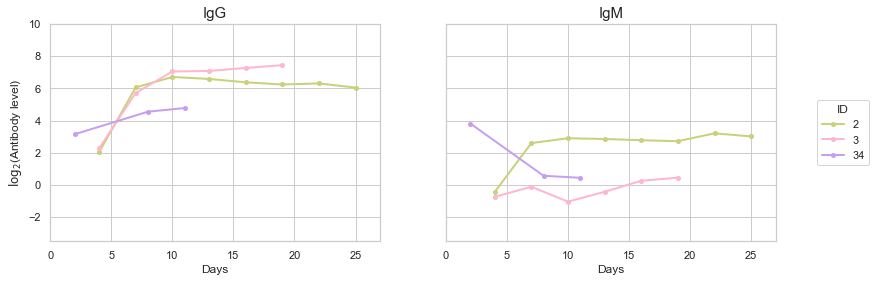

In [183]:
ID_unique = total2_IgG.sort_values(by = ['ID'])['ID'].unique()
np.random.seed(5)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(ID_unique), replace=False)


fig, ax = plt.subplots(1,2, figsize=(13,4), sharey = True)
for i, y  in enumerate(ID_unique):        
            #if i > 0:
                ax[0].plot('Days', 'Antibody level', 
                           data=total2_IgG.loc[total2_IgG.ID==y, :], 
                           color=mycolors[i], 
                           label=y,
                           linewidth=2,
                           marker=".", 
                           markersize=8)

for i, y  in enumerate(ID_unique):        
            #if i > 0:
                ax[1].plot('Days', 'Antibody level', 
                           data=total2_IgM.loc[total2_IgM.ID==y, :], 
                           color=mycolors[i], 
                           label=y,
                           linewidth=2,
                           marker=".", 
                           markersize=8)



ax[0].set_title('IgG', fontsize=15)
ax[1].set_title('IgM', fontsize=15)

ax[0].set_xlabel('Days')
ax[1].set_xlabel('Days')

ax[0].set_ylabel('$\log_2$(Antibody level)')

ax[0].set_xlim(0, 27)
ax[1].set_xlim(0, 27)

ax[0].set_ylim(-3.5, 10)
ax[1].set_ylim(-3.5, 10)

lines, labels = ax[0].get_legend_handles_labels()
lines2, labels2 = ax[1].get_legend_handles_labels()

ax[0].legend(lines, labels,bbox_to_anchor=(2.5, 0.5),loc = 'center right',title="ID")
   
#plt.suptitle('Pacientes 2, 3 y 34', fontsize=20)
plt.savefig('234.pdf', bbox_inches='tight')
plt.show()

## Tabla

In [184]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

In [185]:
df3_export = pd.DataFrame.copy(df3)

In [186]:
df3_export = df3_export.astype({"ID": str, "Days after symptoms onset": str, "IgG (S/CO)": float, "IgM (S/CO)": float, "Severity": str})

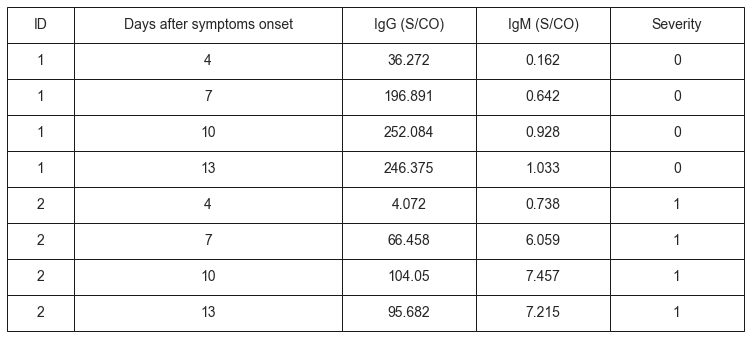

In [187]:
table2 = plt.table(cellText=df3_export.head(8).values, colLabels=df3_export.head(10).columns,
         cellLoc = 'center',
         loc = 'center',
         colLoc = 'center',
         rowLoc = 'center',
         #colColours = ['#F5C1C1']*5,
         edges = 'closed',
         colWidths = [0.05,0.20,0.10,0.10,0.10]
         )
plt.axis('off')
table2.auto_set_font_size(False)
table2.set_fontsize(14)
table2.scale(4, 3)
fig = table2.figure

pp = PdfPages("table2.pdf")
pp.savefig(fig, bbox_inches='tight')
pp.close()

In [188]:
filter_func = Eccentricity(exponent = 2,metric= 'cosine')
cover = OneDimensionalCover(n_intervals=100, overlap_frac=0.88, kind = 'balanced')
#originals 100, 0.88
clusterer = DBSCAN(eps = 0.1,metric='cosine')

n_jobs = 1

# Initialise pipeline
pipe = make_mapper_pipeline(
    scaler = MinMaxScaler(),
    filter_func=filter_func,
    cover=cover,
    contract_nodes=True,
    clusterer=clusterer,
    verbose=False,
    n_jobs=n_jobs,
)
node_scale = 25
fig = plot_static_mapper_graph(pipe, 
                                    df3.drop(['Severity'], axis=1), 
                                    layout_dim=2, 
                                    node_scale=node_scale,
                                    node_color_statistic=np.mean,
                                    color_data = df3[["IgG (S/CO)"]],
                                    plotly_params = {"layout" : {"font_size":14}}
                                   )
fig.write_image("images/fin_g.pdf")

In [189]:
filter_func = Eccentricity(exponent = 2,metric= 'cosine')
cover = OneDimensionalCover(n_intervals=100, overlap_frac=0.88, kind = 'balanced')
#originals 100, 0.88
clusterer = DBSCAN(eps = 0.1,metric='cosine')

n_jobs = 1

# Initialise pipeline
pipe = make_mapper_pipeline(
    scaler = MinMaxScaler(),
    filter_func=filter_func,
    cover=cover,
    contract_nodes=True,
    clusterer=clusterer,
    verbose=False,
    n_jobs=n_jobs,
)
node_scale = 25
fig = plot_static_mapper_graph(pipe, 
                                    df3.drop(['Severity'], axis=1), 
                                    layout_dim=2, 
                                    node_scale=node_scale,
                                    node_color_statistic=np.mean,
                                    color_data = df3[["IgM (S/CO)"]],
                                    plotly_params = {"layout" : {"font_size":14}}
                                   )
fig.write_image("images/fin_m.pdf")

In [190]:
filter_func = Eccentricity(exponent = 2,metric= 'cosine')
cover = OneDimensionalCover(n_intervals=100, overlap_frac=0.88, kind = 'balanced')
#originals 100, 0.88
clusterer = DBSCAN(eps = 0.1,metric='cosine')

n_jobs = 1

# Initialise pipeline
pipe = make_mapper_pipeline(
    scaler = MinMaxScaler(),
    filter_func=filter_func,
    cover=cover,
    contract_nodes=True,
    clusterer=clusterer,
    verbose=False,
    n_jobs=n_jobs,
)
node_scale = 25
fig = plot_static_mapper_graph(pipe, 
                                    df3.drop(['Severity'], axis=1), 
                                    layout_dim=2, 
                                    node_scale=node_scale,
                                    node_color_statistic=np.mean,
                                    color_data = df3[["Days after symptoms onset"]],
                                    plotly_params = {"layout" : {"font_size":14}}
                                   )
fig.write_image("images/fin_d.pdf")

In [191]:
filter_func = Eccentricity(exponent = 2,metric= 'cosine')
cover = OneDimensionalCover(n_intervals=100, overlap_frac=0.88, kind = 'balanced')
#originals 100, 0.88
clusterer = DBSCAN(eps = 0.1,metric='cosine')

n_jobs = 1

# Initialise pipeline
pipe = make_mapper_pipeline(
    scaler = MinMaxScaler(),
    filter_func=filter_func,
    cover=cover,
    contract_nodes=True,
    clusterer=clusterer,
    verbose=False,
    n_jobs=n_jobs,
)
node_scale = 25
fig = plot_static_mapper_graph(pipe, 
                                    df3.drop(['Severity'], axis=1), 
                                    layout_dim=2, 
                                    node_scale=node_scale,
                                    node_color_statistic=np.mean,
                                    color_data = df3[["Severity"]],
                                    plotly_params = {"layout" : {"font_size":14}}
                                   )
fig.write_image("images/fin_s.pdf")